<a href="https://colab.research.google.com/github/tronghieu2810/COMPUTER_VISION/blob/main/ResNet_Fruits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

from glob import glob
import itertools

In [2]:
# Resize all images to this
IMAGE_SIZE = [100, 100]

# Training config
epochs     = 16
batch_size = 128

In [3]:
!wget -nc https://lazyprogrammer.me/course_files/fruits-360.zip

--2022-03-16 11:16:47--  https://lazyprogrammer.me/course_files/fruits-360.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 190820824 (182M) [application/zip]
Saving to: ‘fruits-360.zip’

fruits-360.zip      100%[===================>] 181.98M  20.7MB/s    in 9.5s    

2022-03-16 11:16:57 (19.1 MB/s) - ‘fruits-360.zip’ saved [190820824/190820824]



In [4]:
!unzip -nq fruits-360.zip

In [5]:
train_path = 'fruits-360/Training'
valid_path = 'fruits-360/Validation'

In [6]:
# Useful for getting number of files
image_files       = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')

In [7]:
image_files

['fruits-360/Training/Pear Williams/121_100.jpg',
 'fruits-360/Training/Pear Williams/r_268_100.jpg',
 'fruits-360/Training/Pear Williams/r_215_100.jpg',
 'fruits-360/Training/Pear Williams/r_164_100.jpg',
 'fruits-360/Training/Pear Williams/74_100.jpg',
 'fruits-360/Training/Pear Williams/r_188_100.jpg',
 'fruits-360/Training/Pear Williams/171_100.jpg',
 'fruits-360/Training/Pear Williams/62_100.jpg',
 'fruits-360/Training/Pear Williams/45_100.jpg',
 'fruits-360/Training/Pear Williams/r_9_100.jpg',
 'fruits-360/Training/Pear Williams/r_163_100.jpg',
 'fruits-360/Training/Pear Williams/178_100.jpg',
 'fruits-360/Training/Pear Williams/42_100.jpg',
 'fruits-360/Training/Pear Williams/40_100.jpg',
 'fruits-360/Training/Pear Williams/15_100.jpg',
 'fruits-360/Training/Pear Williams/213_100.jpg',
 'fruits-360/Training/Pear Williams/r_74_100.jpg',
 'fruits-360/Training/Pear Williams/r_59_100.jpg',
 'fruits-360/Training/Pear Williams/r_85_100.jpg',
 'fruits-360/Training/Pear Williams/52_100.

In [8]:
# Useful for getting number of classes
folders = glob(train_path + '/*')
folders

['fruits-360/Training/Pear Williams',
 'fruits-360/Training/Strawberry',
 'fruits-360/Training/Limes',
 'fruits-360/Training/Avocado ripe',
 'fruits-360/Training/Apple Granny Smith',
 'fruits-360/Training/Mango',
 'fruits-360/Training/Plum',
 'fruits-360/Training/Cactus fruit',
 'fruits-360/Training/Kiwi',
 'fruits-360/Training/Kumquats',
 'fruits-360/Training/Pear',
 'fruits-360/Training/Lemon Meyer',
 'fruits-360/Training/Quince',
 'fruits-360/Training/Banana Red',
 'fruits-360/Training/Mandarine',
 'fruits-360/Training/Papaya',
 'fruits-360/Training/Pomegranate',
 'fruits-360/Training/Pitahaya Red',
 'fruits-360/Training/Maracuja',
 'fruits-360/Training/Clementine',
 'fruits-360/Training/Grape White 2',
 'fruits-360/Training/Grapefruit Pink',
 'fruits-360/Training/Kaki',
 'fruits-360/Training/Huckleberry',
 'fruits-360/Training/Dates',
 'fruits-360/Training/Grapefruit White',
 'fruits-360/Training/Apple Golden 3',
 'fruits-360/Training/Carambula',
 'fruits-360/Training/Pear Monster'

In [9]:
# Resnet base
res = ResNet50(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 0s 0us/step


In [10]:
# Don't train the existing weights. Only the final layer will be trained
for layer in res.layers:
    layer.trainable = False

In [11]:
x          = Flatten()(res.output)
prediction = Dense(len(folders), activation='softmax')(x)

# Create a model object
model = Model(inputs=res.input, outputs=prediction)

# View the structure of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 106, 106, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 50, 50, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 50, 50, 64)   256         ['conv1_conv[0][0]']         

In [12]:
# Create an instance of ImageDataGenerator
train_gen = ImageDataGenerator(
    rotation_range=20, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input
)

val_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

In [13]:
# Test generator
# Get label mapping for confusion matrix plot
test_gen = val_gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None] * len(test_gen.class_indices)
for k, v in test_gen.class_indices.items():
    labels[v] = k

Found 9673 images belonging to 60 classes.
{'Apple Braeburn': 0, 'Apple Golden 1': 1, 'Apple Golden 2': 2, 'Apple Golden 3': 3, 'Apple Granny Smith': 4, 'Apple Red 1': 5, 'Apple Red 2': 6, 'Apple Red 3': 7, 'Apple Red Delicious': 8, 'Apple Red Yellow': 9, 'Apricot': 10, 'Avocado': 11, 'Avocado ripe': 12, 'Banana': 13, 'Banana Red': 14, 'Cactus fruit': 15, 'Carambula': 16, 'Cherry': 17, 'Clementine': 18, 'Cocos': 19, 'Dates': 20, 'Granadilla': 21, 'Grape Pink': 22, 'Grape White': 23, 'Grape White 2': 24, 'Grapefruit Pink': 25, 'Grapefruit White': 26, 'Guava': 27, 'Huckleberry': 28, 'Kaki': 29, 'Kiwi': 30, 'Kumquats': 31, 'Lemon': 32, 'Lemon Meyer': 33, 'Limes': 34, 'Litchi': 35, 'Mandarine': 36, 'Mango': 37, 'Maracuja': 38, 'Nectarine': 39, 'Orange': 40, 'Papaya': 41, 'Passion Fruit': 42, 'Peach': 43, 'Peach Flat': 44, 'Pear': 45, 'Pear Abate': 46, 'Pear Monster': 47, 'Pear Williams': 48, 'Pepino': 49, 'Pineapple': 50, 'Pitahaya Red': 51, 'Plum': 52, 'Pomegranate': 53, 'Quince': 54, 'Ra

In [14]:
from sklearn.utils import shuffle
# Create generators
train_generator = train_gen.flow_from_directory(directory=train_path,
                                                target_size=IMAGE_SIZE,
                                                shuffle=True,
                                                batch_size=batch_size,
                                                class_mode='sparse')

valid_generator = val_gen.flow_from_directory  (directory=valid_path,
                                                target_size=IMAGE_SIZE,
                                                shuffle=True,
                                                batch_size=batch_size,
                                                class_mode='sparse')

Found 28736 images belonging to 60 classes.
Found 9673 images belonging to 60 classes.


In [16]:
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Fit the model
r = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=epochs,
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(valid_image_files) // batch_size
)

Epoch 1/16
224/224 [==============================] - 102s 401ms/step - loss: 0.5681 - accuracy: 0.9250 - val_loss: 0.0688 - val_accuracy: 0.9805
Epoch 2/16
224/224 [==============================] - 88s 392ms/step - loss: 0.1684 - accuracy: 0.9741 - val_loss: 0.2971 - val_accuracy: 0.9565
Epoch 3/16
224/224 [==============================] - 88s 393ms/step - loss: 0.1367 - accuracy: 0.9816 - val_loss: 0.1580 - val_accuracy: 0.9824
Epoch 4/16
224/224 [==============================] - 88s 391ms/step - loss: 0.0991 - accuracy: 0.9864 - val_loss: 0.3572 - val_accuracy: 0.9694
Epoch 5/16
224/224 [==============================] - 88s 391ms/step - loss: 0.1039 - accuracy: 0.9871 - val_loss: 0.2154 - val_accuracy: 0.9808
Epoch 6/16
224/224 [==============================] - 90s 401ms/step - loss: 0.1154 - accuracy: 0.9881 - val_loss: 0.4191 - val_accuracy: 0.9760
Epoch 7/16
224/224 [==============================] - 88s 392ms/step - loss: 0.0770 - accuracy: 0.9920 - val_loss: 0.2947 - val_a

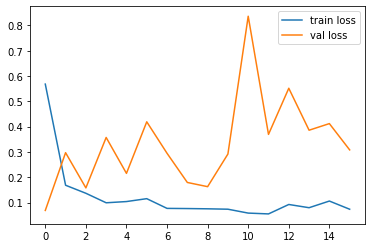

In [17]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()

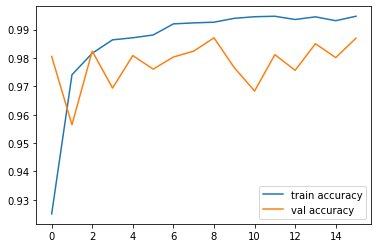

In [18]:
plt.plot(r.history['accuracy'], label='train accuracy')
plt.plot(r.history['val_accuracy'], label='val accuracy')
plt.legend()
plt.show()